In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(10) ##

### load data
dir = 'time_series_top5/'
# df = pd.read_excel('samsung_foreign_simple.xlsx')
df = pd.read_excel(dir + 'samsung_ts_preprocessed3.xlsx')
df

,date,closed,foreign,foreign_price,foreign_volume
0,20040102,8980,-58110,-58110000000,-6.471047e+06
1,20040105,9150,-1816,-1816000000,-1.984699e+05
2,20040106,9200,51037,51037000000,5.547500e+06
3,20040107,9300,20489,20489000000,2.203118e+06
4,20040108,9380,95871,95871000000,1.022079e+07
...,...,...,...,...,...
4899,20231025,68000,-33880,-33880000000,-4.982353e+05
4900,20231026,66700,-91503,-91503000000,-1.371859e+06
4901,20231027,67300,-62420,-62420000000,-9.274889e+05
4902,20231030,67300,-28996,-28996000000,-4.308470e+05


<Axes: xlabel='date', ylabel='foreign_volume'>

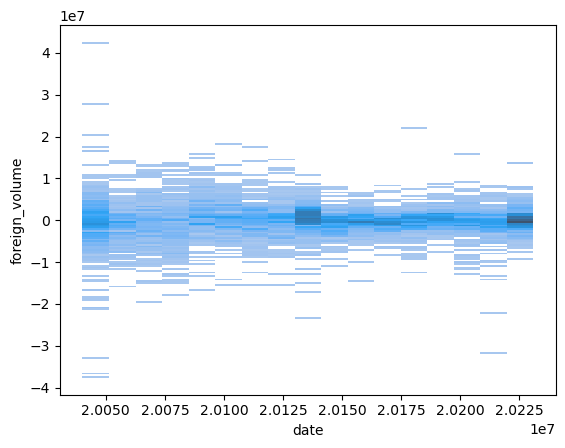

In [2]:
target = 'foreign_volume'
sns.histplot(data=df, x='date', y=target)

In [3]:
### split train and test data
# df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
# df.dtypes

test_sd = 20200303
# test_sd = 20230801
# df['date'].astype('int64')
# test_sd = 20230502
train = df.loc[df['date'] < test_sd]
test = df.loc[df['date'] >= test_sd]
print(len(train), len(test))

3999 905


In [4]:
'''
TRAIN_SPLIT = 3999 # train data 수
# Standardization (Standard Scaling)
uni_data = df['외국인']
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization
## scaling
'''

### scale for train data
abs_max = train[target].abs().max() # 1121643
train['scaled'] = train[target] / abs_max
train.describe()

/var/folders/6f/2n431_rd0_9_wzfc451bx8tr0000gn/T/ipykernel_51943/2964398104.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['scaled'] = train[target] / abs_max


,date,closed,foreign,foreign_price,foreign_volume,scaled
count,3.999000e+03,3999.000000,3.999000e+03,3.999000e+03,3.999000e+03,3999.000000
mean,2.011628e+07,23853.503376,-4.188460e+03,-4.188460e+09,-2.424007e+05,-0.005689
std,4.659583e+04,13446.027545,8.370446e+04,8.370446e+10,4.193351e+06,0.098415
min,2.004010e+07,8040.000000,-6.652110e+05,-6.652110e+11,-3.770590e+07,-0.884935
25%,2.008011e+07,12060.000000,-4.358600e+04,-4.358600e+10,-2.074423e+06,-0.048685
50%,2.012011e+07,21340.000000,-2.191000e+03,-2.191000e+09,-1.019624e+05,-0.002393
75%,2.016016e+07,29580.000000,3.682200e+04,3.682200e+10,1.701615e+06,0.039936
max,2.020030e+07,62400.000000,1.121643e+06,1.121643e+12,4.260866e+07,1.000000


In [6]:
test['scaled'] = test[target] / abs_max
test.describe()

/var/folders/6f/2n431_rd0_9_wzfc451bx8tr0000gn/T/ipykernel_51943/3953775004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['scaled'] = test[target] / abs_max


,date,closed,foreign,foreign_price,foreign_volume,scaled
count,9.050000e+02,905.000000,9.050000e+02,9.050000e+02,9.050000e+02,905.000000
mean,2.021561e+07,67042.320442,-1.748709e+04,-1.748709e+10,-2.451157e+05,-0.005753
std,1.070879e+04,10116.565324,2.233365e+05,2.233365e+11,3.222263e+06,0.075625
min,2.020030e+07,42500.000000,-2.356681e+06,-2.356681e+12,-3.167582e+07,-0.743413
25%,2.021013e+07,59300.000000,-1.007400e+05,-1.007400e+11,-1.545563e+06,-0.036273
50%,2.021123e+07,67000.000000,-1.056800e+04,-1.056800e+10,-1.725257e+05,-0.004049
75%,2.022113e+07,74400.000000,8.306700e+04,8.306700e+10,1.286520e+06,0.030194
max,2.023103e+07,91000.000000,9.525110e+05,9.525110e+11,1.571377e+07,0.368793


In [7]:
# Define a specific window for training Neural Network
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    # dataset: 시계열 데이터셋. 이 데이터셋은 단일 변수(단일 열)로 가정됩니다.
    # start_index: 데이터셋에서 추출할 시계열 데이터의 시작 인덱스.
    # end_index: 데이터셋에서 추출할 시계열 데이터의 끝 인덱스. None으로 설정되면 데이터셋의 끝까지 사용.
    # history_size: 입력으로 사용할 과거 데이터의 크기 (타임 스텝 수)
    # target_size: 레이블로 사용할 미래의 데이터 크기 (타임 스텝 수)
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [8]:
df2 = pd.concat([train, test])
df2

,date,closed,foreign,foreign_price,foreign_volume,scaled
0,20040102,8980,-58110,-58110000000,-6.471047e+06,-0.151872
1,20040105,9150,-1816,-1816000000,-1.984699e+05,-0.004658
2,20040106,9200,51037,51037000000,5.547500e+06,0.130197
3,20040107,9300,20489,20489000000,2.203118e+06,0.051706
4,20040108,9380,95871,95871000000,1.022079e+07,0.239876
...,...,...,...,...,...,...
4899,20231025,68000,-33880,-33880000000,-4.982353e+05,-0.011693
4900,20231026,66700,-91503,-91503000000,-1.371859e+06,-0.032197
4901,20231027,67300,-62420,-62420000000,-9.274889e+05,-0.021768
4902,20231030,67300,-28996,-28996000000,-4.308470e+05,-0.010112


In [9]:
uni_data = df2['scaled'].values
TRAIN_SPLIT = len(train) #4782
TRAIN_SPLIT

3999

In [10]:
univariate_past_history = 60 # 30 days
univariate_future_target = 0

## univariate_data 함수 이용해 데이터셋 생성
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target to predict')
print(y_train_uni[0])

Single window of past history
[[-0.15187163]
 [-0.00465797]
 [ 0.13019653]
 [ 0.05170588]
 [ 0.23987585]
 [ 1.        ]
 [ 0.06236356]
 [ 0.14991725]
 [-0.12778131]
 [ 0.13712468]
 [ 0.06832566]
 [ 0.12555006]
 [ 0.18339601]
 [ 0.65059994]
 [-0.02798343]
 [ 0.06600007]
 [-0.04275791]
 [-0.03367457]
 [ 0.03208888]
 [-0.1522538 ]
 [-0.13895134]
 [-0.2044795 ]
 [ 0.15759239]
 [ 0.1598621 ]
 [ 0.14904363]
 [ 0.09052455]
 [-0.13215328]
 [ 0.11084537]
 [ 0.25186884]
 [-0.00977543]
 [-0.01894225]
 [ 0.01982636]
 [ 0.07623496]
 [-0.20758626]
 [-0.13682531]
 [-0.26260254]
 [-0.02327532]
 [-0.00951049]
 [ 0.16021683]
 [ 0.12529444]
 [ 0.15561165]
 [ 0.13157224]
 [-0.05458026]
 [-0.164214  ]
 [-0.10497366]
 [-0.00645959]
 [-0.13006933]
 [-0.0836919 ]
 [-0.10991283]
 [ 0.03858672]
 [-0.04305385]
 [ 0.04584569]
 [-0.02186883]
 [-0.12577173]
 [-0.01509923]
 [-0.09357274]
 [ 0.09228644]
 [ 0.04273969]
 [ 0.14127116]
 [ 0.3938429 ]]

 Target to predict
0.08917762267204135


In [11]:
# train data, validation data 개수 확인
print(len(x_train_uni), len(y_train_uni))
print(len(x_val_uni), len(y_val_uni))

3939 3939
845 845


In [12]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

train_steps = len(x_train_uni) / BATCH_SIZE
print('train_steps :', train_steps, int(train_steps))
val_steps = len(x_val_uni) / BATCH_SIZE
print('val_steps :', val_steps, int(val_steps))

train_steps : 30.7734375 30
val_steps : 6.6015625 6


In [13]:
# 학습데이터 제공 파이프라인
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

# cache(): 데이터를 메모리 또는 로컬 파일 시스템에 캐시
# shuffle(): 데이터를 섞어을 때 사용되는 버퍼의 크기
# batch(): 배치 크기에 따라 데이터를 미니배치로 
# repeat(): 데이터셋을 여러 에포크 동안 반복

Metal device set to: Apple M2


2023-12-14 02:30:25.234723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 02:30:25.239179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# to check the number
np.array(x_train_uni).shape[-2:]

(60, 1)

In [15]:
# model
# tf.keras.optimizers.Optimizer.variables
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=np.array(x_train_uni).shape[-2:]),
    tf.keras.layers.Dense(1)
])

# simple_lstm_model.compile(optimizer='adam', loss='mae') #loss(mae, mape)
simple_lstm_model.compile(optimizer='adam', loss='mae') #loss(mae, mape)

In [16]:
# 모델 학습
EPOCHS = 100

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=train_steps,
                      validation_data=val_univariate,
                      validation_steps=val_steps)

# train_univariate: 훈련 데이터셋으로서, 앞서 언급한 univariate_data 함수를 사용하여 생성된 데이터
# epochs:지정된 에포크 횟수
# validation_data: 검증 데이터셋으로서, 훈련 중에 모델 성능을 평가하는 데 사용

Epoch 1/100


2023-12-14 02:30:44.054056: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-14 02:30:44.060288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-14 02:30:44.252154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-14 02:30:45.992581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 0.0611

2023-12-14 02:30:50.568097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-14 02:30:50.605695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 9s 131ms/step - loss: 0.0611 - val_loss: 0.0440
Epoch 2/100
30/30 [==============================] - 1s 23ms/step - loss: 0.0604 - val_loss: 0.0438
Epoch 3/100
30/30 [==============================] - 1s 20ms/step - loss: 0.0604 - val_loss: 0.0439
Epoch 4/100
30/30 [==============================] - 1s 20ms/step - loss: 0.0602 - val_loss: 0.0440
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0601 - val_loss: 0.0437
Epoch 6/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0599 - val_loss: 0.0436
Epoch 7/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0597 - val_loss: 0.0438
Epoch 8/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0597 - val_loss: 0.0436
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0597 - val_loss: 0.0436
Epoch 10/100
30/30 [==============================] - 1s 21ms/step - loss: 0.0595 - val_loss: 0.0435
Epoch 11/1

In [17]:
# Defind function for Visualization
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

2023-12-14 02:33:06.947120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-14 02:33:06.987291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 10ms/step


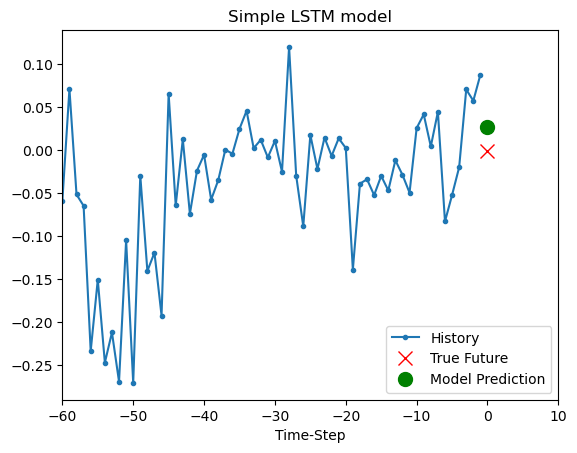

4/4 [==============================] - 0s 10ms/step


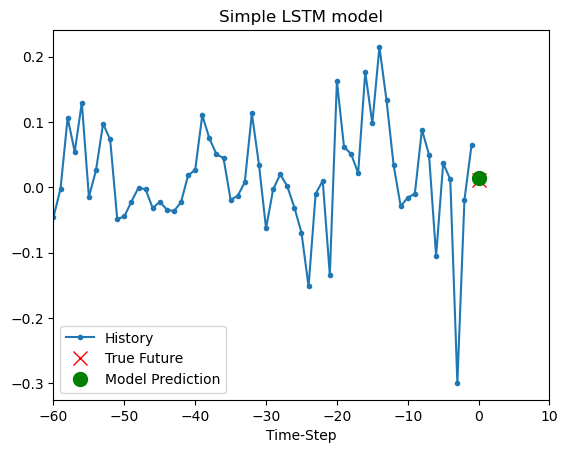

4/4 [==============================] - 0s 10ms/step


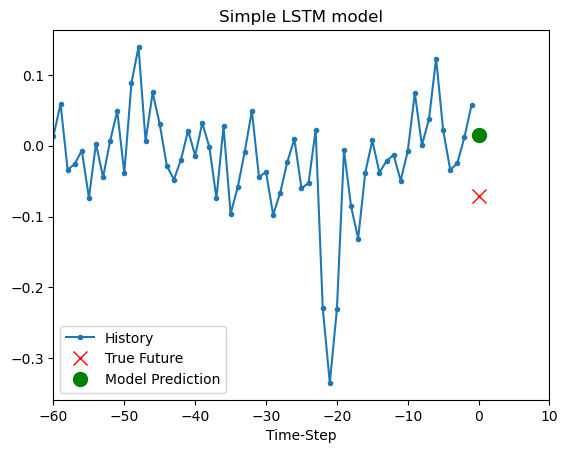

4/4 [==============================] - 0s 10ms/step


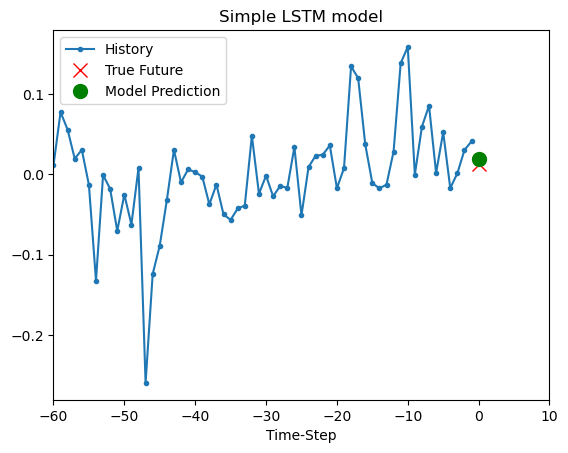

4/4 [==============================] - 0s 10ms/step


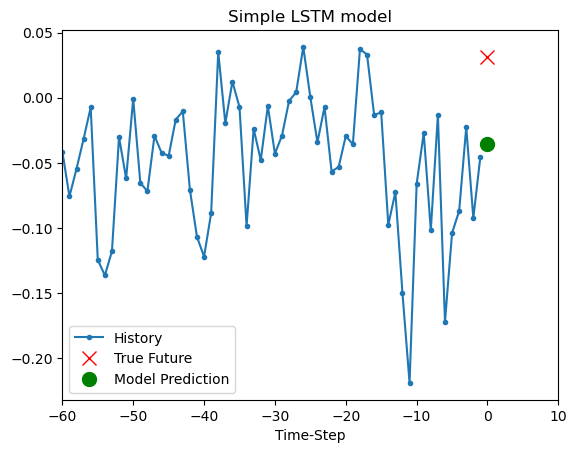

4/4 [==============================] - 0s 8ms/step


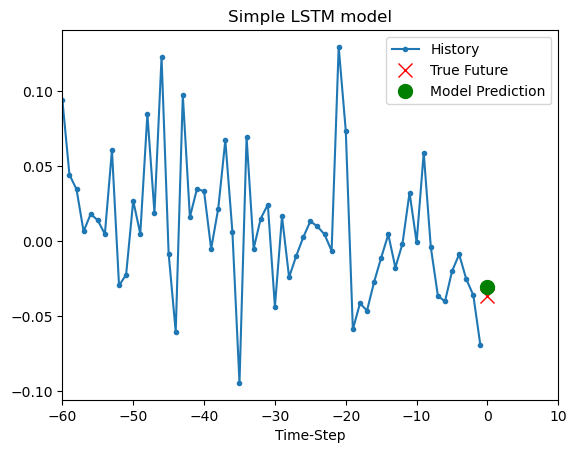

2023-12-14 02:33:08.786441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-12-14 02:33:08.851350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 210ms/step


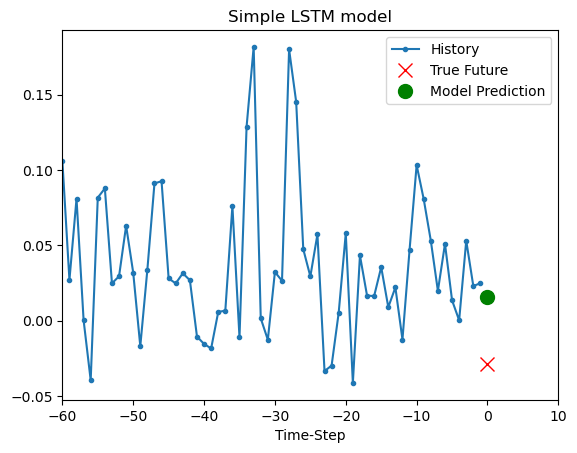

In [18]:
for x, y in val_univariate.take(7):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [19]:
simple_lstm_model.save('simple_lstm_model')

INFO:tensorflow:Assets written to: simple_lstm_model/assets


INFO:tensorflow:Assets written to: simple_lstm_model/assets


In [31]:
cnt = 0
for x, y in val_univariate.take(1):
    # print(cnt)
    # print(x, y)
    # print()
    # cnt =+ 1
    print(y[0].numpy(), simple_lstm_model.predict(x)[0]) #[0]

4/4 [==============================] - 0s 12ms/step
-0.0009117314404579306 [0.02731108]


In [27]:
x

<tf.Tensor: shape=(128, 60, 1), dtype=float64, numpy=
array([[[-0.05912596],
        [ 0.07141037],
        [-0.05147921],
        ...,
        [ 0.0708809 ],
        [ 0.05772263],
        [ 0.08812554]],

       [[ 0.07141037],
        [-0.05147921],
        [-0.06469332],
        ...,
        [ 0.05772263],
        [ 0.08812554],
        [-0.00091173]],

       [[-0.05147921],
        [-0.06469332],
        [-0.23402852],
        ...,
        [ 0.08812554],
        [-0.00091173],
        [-0.00801841]],

       ...,

       [[-0.03419605],
        [-0.02887557],
        [ 0.09381729],
        ...,
        [-0.10476236],
        [ 0.03676793],
        [ 0.01205921]],

       [[-0.02887557],
        [ 0.09381729],
        [-0.04582993],
        ...,
        [ 0.03676793],
        [ 0.01205921],
        [-0.29936301]],

       [[ 0.09381729],
        [-0.04582993],
        [-0.00184391],
        ...,
        [ 0.01205921],
        [-0.29936301],
        [-0.01917014]]])>